# Computer Assignment 5 Phase 1 - Neural Networks
## Artificial Intelligence Course, University of Tehran
## Spring 2021

## 0. Before We Begin

The following library imports were needed in our implementation of the neural network, as well as drawing plots:

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt

## 1. Dataloader

This class will be a handy tool for providing batches of data to our network. The `__onehot` method will generate a one-hot array from the original column vector passed as labels.

In [2]:
class Dataloader:
    
    def __init__(self, data, labels, n_classes, batch_size=None, shuffle=False):

        assert len(data)==len(labels)
        self.__n_classes = n_classes
        self.__batch_size = batch_size
        self.__shuffle = shuffle
        self.__data = data
        self.__onehot_labels = self.__onehot(labels, self.__n_classes)
    
    def __onehot(self, labels, n_classes):
        labels_df = pd.DataFrame(data=labels, columns=['label'])
        onehot_df = pd.get_dummies(labels_df['label'])
        onehot_vectors = onehot_df.to_numpy()
        return onehot_vectors
    
    def __shuffle_dataset(self):
        res = np.random.shuffle(self.__data)
        self.__data = res
    
    def __iter__(self):
        
        if self.__shuffle:
            self.__shuffle_dataset()
            
        if self.__batch_size==None:
            yield (np.matrix(self.__data), np.matrix(self.__onehot_labels))
            return
            
        for idx in range(0, len(self.__data), self.__batch_size):
            yield (np.matrix(self.__data[idx:idx+self.__batch_size]), 
                   np.matrix(self.__onehot_labels[idx:idx+self.__batch_size]))

## 2. Activation Functions

These classes would also come handy when we need to perform operations related to the activation function in a particular layer of our network; the only function with no derivative is $\text{softmax}(\mathbf{x})$, which is not an ordinary function and would provide a complicated derivative which is not necessary in our assignment.

In [3]:
class Identical:
    
    def __init__(self): pass
    
    def __val(self, matrix):
        identical_value = np.array(matrix, dtype=float)
        return identical_value

    def derivative(self, matrix):
        temp = np.array(matrix, dtype=float)
        identical_derivative = np.array(np.full(np.shape(temp), 1.))
        return identical_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)
    

class Relu:
    
    def __init__(self): pass
    
    def __val(self, matrix):
        relu_value = np.where(matrix > 0, matrix, .0)
        return relu_value

    def derivative(self, matrix):
        relu_derivative = np.where(matrix > 0, 1.0, .0)
        return relu_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)

    
class LeakyRelu:
    
    def __init__(self, negative_slope=0.01):
        self.negative_slope = 0.01
    
    def __val(self, matrix):
        leaky_relu_value = np.where(matrix > 0, matrix, matrix * 0.01)
        return leaky_relu_value

    def derivative(self, matrix):
        leaky_relu_derivative = np.where(matrix > 0, 1.0, 0.01)
        return leaky_relu_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)

    
class Sigmoid:
    
    def __init__(self): pass

    def __val(self, matrix):
        sigmoid_value = 1 / (1 + np.exp(-matrix))
        return sigmoid_value

    def derivative(self, matrix):
        s = self.__val(matrix)
        sigmoid_derivative = np.multiply(s, 1 - s)
        return sigmoid_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)


class Softmax:
    
    def __init__(self): pass

    def __val(self, matrix):
        mat = matrix - np.max(matrix, axis=-1, keepdims=True)
        softmax_value = np.exp(mat) / np.exp(mat).sum(axis=-1, keepdims=True)
        return softmax_value
    
    def __call__(self, matrix):
        return self.__val(matrix)
    
class Tanh:
    
    def __init__(self): pass

    def __val(self, matrix):
        tanh_value = np.exp(matrix) - np.exp(-matrix)
        tanh_value /= np.exp(matrix) + np.exp(-matrix)
        return tanh_value

    def derivative(self, matrix):
        tanh_derivative = 1 - np.power(self.__val(matrix), 2)
        return tanh_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)

## 3. Loss Function

Cross-Entropy loss function is defined as follows:

$$H(\mathbf{t},\mathbf{p})=-\sum_i t_i\log(p_i)$$

Assuming we apply $\text{softmax}$ as the activation function of our last layer, we can get a very straightforward relation as the derivative of Cross-Entropy:

$$\frac{\partial H}{\partial p_i}=p_i-t_i$$

Note that we need to apply $\text{softmax}$ to predicted values before calculating the derivative expression.

In [4]:
class CrossEntropy: #(with softmax)
    
    def __init__(self):
        self.eps = 1e-10
        self.softmax = Softmax()
        
    def __val(self, true_val, expected_val):
        assert np.shape(true_val)==np.shape(expected_val)
        true_softmax = self.softmax(np.where(true_val > self.eps, true_val, self.eps))
        loss = np.multiply(expected_val, np.log(true_softmax+self.eps))
        cross_entropy_value = -loss.sum().sum()
        return cross_entropy_value
        
    def derivative(self, true_val, expected_val):
        assert np.shape(true_val)==np.shape(expected_val)
        true_softmax = self.softmax(true_val)
        cross_entropy_derivative = true_softmax - expected_val
        return cross_entropy_derivative
    
    def __call__(self, true_val, expected_val):
        return self.__val(true_val, expected_val)

## 4. Layer

In [5]:
class Layer:

    DEFAULT_LOW, DEFAULT_HIGH, DEFAULT_MEAN, DEFAULT_VAR = 0, 0.005, 0., 1.
  
    def __init__(self, input_size, output_size, 
                 activation=Identical(), initial_weight='uniform', **initializing_parameters):
        
        assert type(initial_weight)==str, 'Undefined activation function!'
        
        self.__weight_initializer_dict = {'uniform':self.__uniform_weight, 'normal':self.__normal_weight}
        
        assert initial_weight in self.__weight_initializer_dict, 'Undefined weight initialization function!'


        self.__n_neurons = output_size
        weight_initializer = self.__weight_initializer_dict[initial_weight]
        self.__weight = weight_initializer(input_size, self.__n_neurons, **initializing_parameters)
        self.__bias = weight_initializer(1, self.__n_neurons, **initializing_parameters)
        self.__activation = activation
        
        self.__last_input = None
        self.__last_activation_input = None
        self.__last_activation_output = None
        self.__last_activation_derivative = None
        
    def forward(self, layer_input):
        assert np.ndim(layer_input)==2
        assert np.size(self.__weight,0) == np.size(layer_input,1)
        
        self.__last_input = layer_input
        self.__last_activation_input =  np.clip(layer_input @ self.__weight + self.__bias, -1e3, 1e3)
        self.__last_activation_output = np.clip(self.__activation(self.__last_activation_input), -1e3, 1e3)
        self.__last_activation_derivative = np.clip(self.__activation.derivative(self.__last_activation_input), -1e3, 1e3)
        
        return self.__last_activation_output
    
    def update_weights(self, backprop_tensor, lr):
        backprop_tensor = np.squeeze(backprop_tensor)
        
        assert np.ndim(backprop_tensor)==2
        assert np.size(backprop_tensor,0) == np.size(self.__last_activation_derivative,0)
        assert np.size(backprop_tensor,1) == self.__n_neurons

        x = self.__last_input
        
        nabla_y = np.multiply(backprop_tensor, self.__last_activation_derivative)
        nabla_y = np.clip(nabla_y, -1e3, 1e3)
        
        bias_coef = np.matrix(np.tile(1, (1, nabla_y.shape[0])))
        
        nabla_w = x.T @ nabla_y
        nabla_b = bias_coef @ nabla_y
        
        self.__weight-= nabla_w * lr
        self.__bias -= nabla_b * lr
        
        backprop_tensor = nabla_y @ self.__weight.T

        return backprop_tensor

    def __uniform_weight(self, dim1, dim2, **initializing_parameters):
        low, high = self.DEFAULT_LOW, self.DEFAULT_HIGH
        if 'low' in initializing_parameters.keys(): low = initializing_parameters['low']
        if 'high' in initializing_parameters.keys(): high = initializing_parameters['high']
        weights = np.random.uniform(low=low, high=high, size=(dim1, dim2))
        return weights

    def __normal_weight(self, dim1, dim2, **initializing_parameters):
        mean, var = self.DEFAULT_MEAN, self.DEFAULT_VAR
        if 'mean' in initializing_parameters.keys(): mean = initializing_parameters['mean']
        if 'var' in initializing_parameters.keys(): var = initializing_parameters['var']
        weights = np.random.normal(mean, np.sqrt(var), size=(dim1, dim2))
        return weights
    
    @property
    def n_neurons(self): return self.__n_neurons
    
    @property
    def weight(self): return self.__weight
    
    @property
    def bias(self): return self.__bias
    
    @property
    def activation(self): return self.__activation

Each layer $l$ receives an input $x$, which is a matrix of size $b\times n_{l-1}$; the weight vector $W$ is an $n_{l-1}\times{n_l}$ matrix, and we also use a bias matrix $b$ with size $b\times n_l$; Forwarding in each layer would then be expressed with the following function:

$$z^{(l)}=xW+b,\;a^{(l)}=\sigma\big(z^{(l)}\big)$$

In [6]:
l = Layer(10, 5, LeakyRelu())
display(pd.DataFrame(l.weight))
display(pd.DataFrame(l.bias))

,0,1,2,3,4
0,0.000168,0.002972,0.004307,0.002479,0.003657
1,0.003867,0.002504,0.002499,0.003021,0.001842
2,0.004842,0.000131,0.001810,0.000297,0.000368
3,0.002060,0.000479,0.004317,0.003266,0.002192
4,0.001855,0.001934,0.002610,0.004026,0.003469
5,0.000918,0.003423,0.001446,0.003318,0.003265
6,0.001614,0.003155,0.003317,0.002576,0.004287
7,0.001100,0.004476,0.000688,0.004862,0.004160
8,0.004164,0.002782,0.004635,0.004703,0.001255
9,0.001841,0.000853,0.002162,0.000870,0.002717


,0,1,2,3,4
0,0.00062,0.001502,0.001502,0.002077,0.002782


## 5. Feed Forward Neural Network

In [6]:
class FeedForwardNN:
    
    def __init__(self, input_shape):
        
        self.__input_shape = input_shape
        self.__output_shape = None
        
        self.__layers_list = []
        
        self.__lr = None
        self.__loss = None

        
    def add_layer(self, n_neurons, activation=Relu(), initial_weight='uniform', **initializing_parameters):
         
        assert type(n_neurons)==int, "Invalid number of neurons for the layer!"
        assert n_neurons>0, "Invalid number of neurons for the layer!"
        
        n_prev_neurons = self.__input_shape if len(self.__layers_list)==0 else self.__layers_list[-1].n_neurons
        new_layer = Layer(n_prev_neurons, n_neurons, activation, initial_weight, **initializing_parameters)
        self.__layers_list.append(new_layer)
        self.__output_shape = self.__layers_list[-1].n_neurons 
      
    
    def set_training_param(self, loss=CrossEntropy(), learning_rate=1e-3):
        assert self.__layers_list, "Uncomplete model!"
        self.__loss = loss
        self.__lr = learning_rate
    
    
    def forward(self, network_input):
        assert type(self.__output_shape) != None, "Model is not compiled!"
        a = [np.array([]) for i in range(len(self.__layers_list) + 1)]
        
        a[0] = network_input
        
        for i in range(1, len(a)):
            a[i] = self.__layers_list[i - 1].forward(a[i - 1])
        
        network_output = a[-1]
        return network_output
    
    
    def fit(self, epochs, trainloader, testloader=None, print_results=True):
        
        assert type(self.__output_shape) != None, "Model is not compiled!"
        assert type(self.__lr) != None and type(self.__loss) != None, "Training paramenters are not set!"

        log = {"train_accuracy":[], "train_loss":[], "test_accuracy":[], "test_loss":[]}
        
        for epoch in range(1, epochs+1):
            
            if print_results: 
                print('Epoch {}:'.format(epoch)) 
                
            average_accuracy, average_loss = self.__train(trainloader)
            log['train_accuracy'].append(average_accuracy)
            log['train_loss'].append(average_loss)
            if print_results:
                print('\tTrain: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))
            
            if type(testloader) != type(None):
                average_accuracy, average_loss = self.__test(testloader)
                log['test_accuracy'].append(average_accuracy)
                log['test_loss'].append(average_loss)
                if print_results:
                    print('\tTest: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))
                    
        return log
    
    
    def __train(self, trainloader):
        batch_accuracies, batch_losses = [], []
        for x_train, y_train in trainloader:
            batch_accuracy, batch_loss = self.__train_on_batch(x_train, y_train)
            batch_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(batch_accuracies), np.mean(batch_losses)
    
    
    def __test(self, testloader):
        batch_accuracies, batch_losses = [], []
        for x_test, y_test in testloader:
            batch_accuracy, batch_loss = self.__test_on_batch(x_test, y_test)
            batch_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(batch_accuracies), np.mean(batch_losses)

    
    def __train_on_batch(self, x_batch, y_batch):
        cross_ent = CrossEntropy()
        batch_accuracy = .0
        
        delta = [np.array([]) for i in range(3)]
        y_pred = self.forward(x_batch)
        
        batch_average_loss = cross_ent(y_pred, y_batch) / len(x_batch)
        batch_accuracy = self.__compute_accuracy(self.__get_labels(y_pred), self.__get_labels(y_batch))
        self.__update_weights(y_pred, y_batch)
        
        return (batch_accuracy, batch_average_loss)
        
        
    def __test_on_batch(self, x_batch, y_batch):
        cross_ent = CrossEntropy()
        batch_accuracy = .0
        
        delta = [np.array([]) for i in range(3)]
        y_pred = self.forward(x_batch)
        
        batch_average_loss = cross_ent(y_pred, y_batch) / len(x_batch)
        batch_accuracy = self.__compute_accuracy(self.__get_labels(y_pred), self.__get_labels(y_batch))
        
        return (batch_accuracy, batch_average_loss)
    
    def __get_labels(self, outputs):
        labels = outputs.argmax(axis=1).reshape(len(outputs), 1)
        return labels
    
    
    def __compute_accuracy(self, output, expected_output):
        cnt = 0
        for i in range(len(output)):
            cnt += (output[i] == expected_output[i])
            
        return cnt / len(output)
    
    def __update_weights(self, output, y_train):
        cross_ent = CrossEntropy()
        delta = cross_ent.derivative(output, y_train)
        delta = np.clip(delta, -1e3, 1e3)
        
        for i in range(1, len(self.__layers_list) + 1):
            layer = self.__layers_list[-i]
            delta = layer.update_weights(delta, self.__lr)
        return

The following set of equations are used for implementing backpropagation in our network; as an extensive amount of explanation is needed for demonstrating the correctness of these equations, we would just suffice to bringing them here.

For each layer $l$ in our network (except the input layer,) we define $\delta^{(l)}$ as follows:

$$\delta^{(l)}=\frac{\partial C}{\partial z^{(l)}}$$

For each layer, we can calculate $\delta$ from the value calculated for the next layer; more explicitly, we have:

$$\delta^{(l)}=\Big(\delta^{(l+1)}{\big(W^{(l+1)}\big)}^T\Big)\odot \sigma'\big(z^{(l)}\big)$$

Our final step would be caculating the following equations:

$$\frac{\partial C}{\partial W^{(l)}}= x^{(l)}\delta^{(l)},\;\frac{\partial C}{\partial b^{(l)}}\equiv\delta^{(l)}$$

With the equations described above, we can run Gradient Descent on our network.

__Note:__ To avoid overflow in our network due to chained multiplications (or extreme gradients) we have clipped some particular values to the range $[-10^3, 10^3]$ to keep our network in a stable state.

## 6. Preprocessing

Each row in `x_train`, `x_test` is the flattened form of a picture with $28\times 28$ pixels; each pixel has an integer value in range $[0, 255]$.

In [7]:
x_train = pd.read_csv('./dataset/train_images.csv')
y_train = pd.read_csv('./dataset/train_labels.csv')

x_test = pd.read_csv('./dataset/test_images.csv')
y_test = pd.read_csv('./dataset/test_labels.csv')

for df in [x_train, x_test, y_train, y_test]:
    df.drop(['Unnamed: 0'], axis=1, inplace=True)

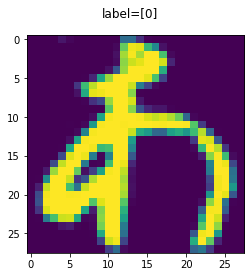

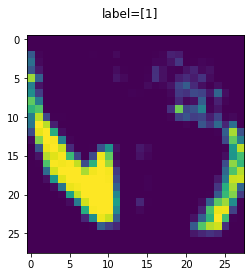

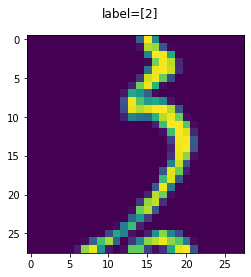

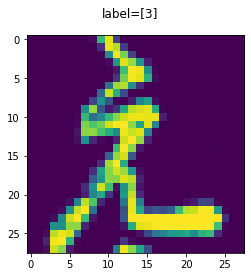

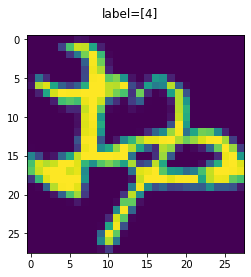

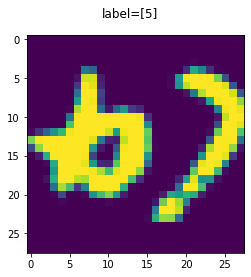

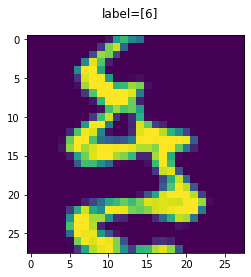

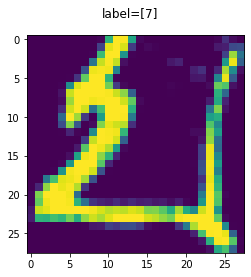

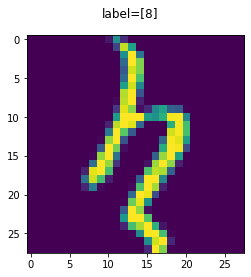

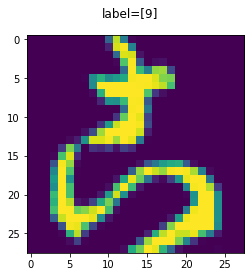

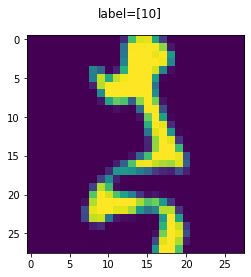

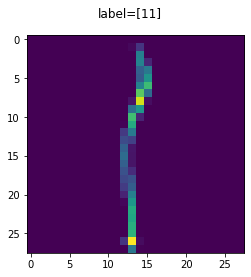

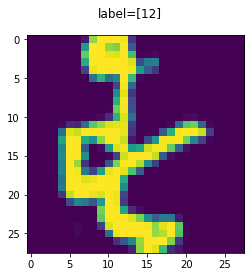

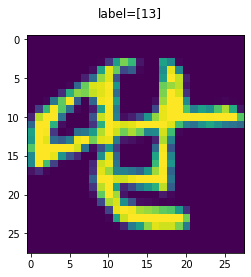

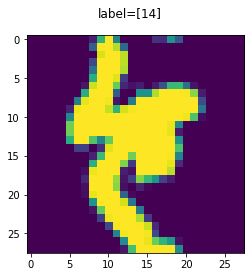

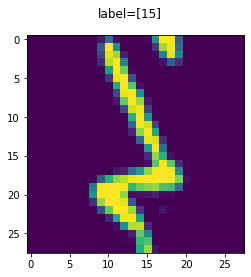

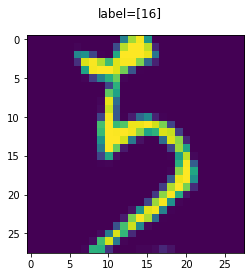

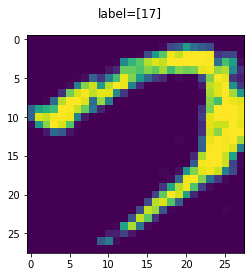

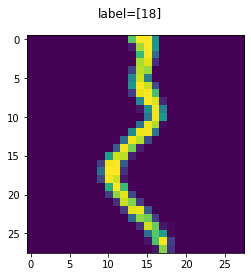

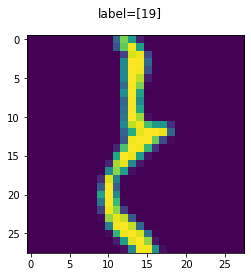

In [9]:
img_sel = y_train.groupby('0').sample(n=1)
img_list = img_sel.index.tolist()

for i in range(len(img_list)):
    fig = plt.figure()
    plt.imshow(x_train.values[img_list[i]].reshape(28, 28))
    fig.suptitle(f'label={img_sel.values[i]}')
    plt.show()

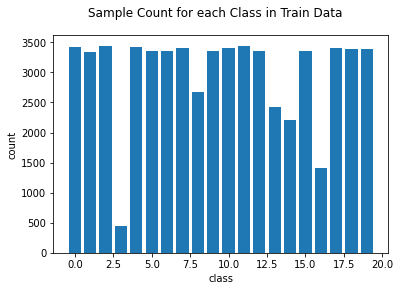

In [10]:
index, counts = np.unique(y_train['0'].values, return_counts = True)
plt.bar(index, counts)
plt.suptitle('Sample Count for each Class in Train Data')
plt.xlabel('class')
plt.ylabel('count')
plt.show()

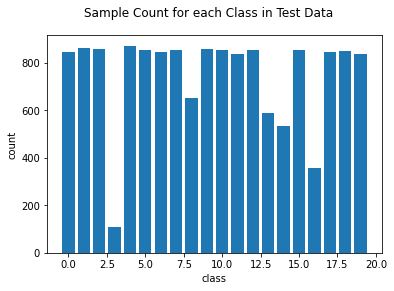

In [11]:
index, counts = np.unique(y_test['0'].values, return_counts = True)
plt.bar(index, counts)
plt.suptitle('Sample Count for each Class in Test Data')
plt.xlabel('class')
plt.ylabel('count')
plt.show()

Scaling our features would help the performance of our network; therefore we use the following method to scale values for all features in the range $[0, 1]$

In [8]:
max_, min_ = x_train.max(), x_train.min()
x_train = (x_train - min_) / (max_ - min_)
x_test = (x_test - min_) / (max_ - min_)

display(x_train)
display(x_test)

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.043137,0.011765,0.043137,0.007843,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.090196,0.647059,0.141176,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.05098,0.196078,0.184314,0.219608,0.368627,0.141176,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.015686,0.619608,...,1.000000,0.968627,0.768627,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
59996,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
59997,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,1.000000,1.000000,0.298039,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
59998,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.576471,...,0.117647,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.011765,0.392157,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.121569,0.854902,0.168627,0.000000,0.000000,...,0.078431,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.035294,0.835294,0.992157,0.380392,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.196078,0.713725,...,0.262745,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
14996,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.0,0.796078,0.062745,0.0,0.0,0.0,0.0,0.0,0.0
14997,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.011765,0.560784,0.996078,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
14998,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


The following cell contains some demonstrations for the functions we use as activation functions.

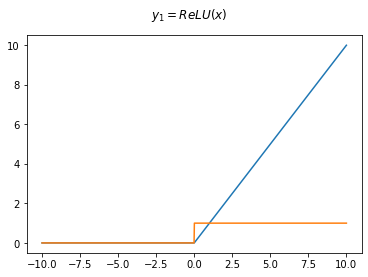

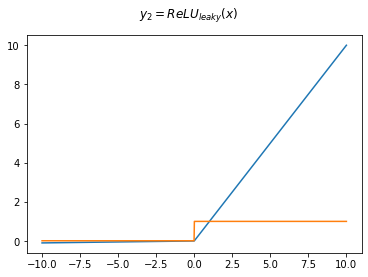

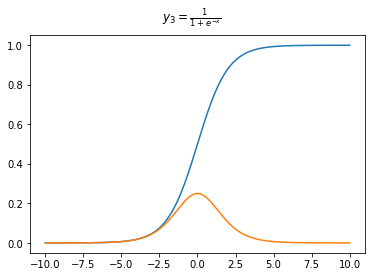

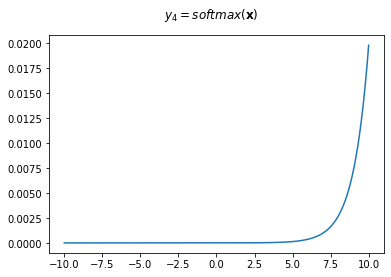

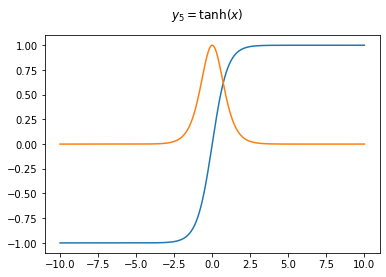

In [13]:
x = np.linspace(-10, +10, 1000)

y1 = Relu()(x)
dy1 = Relu().derivative(x)
plt.plot(x, y1)
plt.plot(x, dy1)
plt.suptitle(r'$y_1=ReLU(x)$')
plt.show()

y2 = LeakyRelu()(x)
dy2 = LeakyRelu().derivative(x)
plt.plot(x, y2)
plt.plot(x, dy2)
plt.suptitle(r'$y_2={ReLU}_{leaky}(x)$')
plt.show()


y3 = Sigmoid()(x)
dy3 = Sigmoid().derivative(x)
plt.plot(x, y3)
plt.plot(x, dy3)
plt.suptitle(r'$y_3=\frac{1}{1+e^{-x}}$')
plt.show()

y4 = Softmax()(x)
plt.plot(x, y4)
plt.suptitle(r'$y_4=softmax(\mathbf{x})$')
plt.show()

y5 = Tanh()(x)
dy5 = Tanh().derivative(x)
plt.plot(x, y5)
plt.plot(x, dy5)
plt.suptitle(r'$y_5=\tanh(x)$')
plt.show()

## 7. First Try on Training a Model

For this problem, we will train a network with 2 hidden layers with size 32. The values for internal nodes are not too low or high in comparison to their neighbor layers, and it turned out to be that this value does not really matter in our problem.

The first model we trained was, well, not the best model we expected; there are certain things we can do to improve the performance of this model:

1. Gradient Descent is, in principle, an approximative algorithm; the versatility of this algorithm comes in sight if appropriate parameters are provided for its execution. In our case, a proportionally high learning rate keeps our model in a local minimum for cost function, and performance barely improves after 20 epochs.


2. Maybe considering other functions for output and hidden layer activations would not be a totally bad idea; we'll see that leaky ReLU can be our best choice for output layer activation, in this particular model of course.

In [9]:
# Sample code for building and training a model
BATCH_SIZE = 64
INPUT_SHAPE = 28*28
LEARNING_RATE = 1e-3
EPOCHS = 20
TRAINLOADER = Dataloader(data=x_train.to_numpy(), labels=y_train.to_numpy(), n_classes=20, batch_size=BATCH_SIZE)
TESTLOADER = Dataloader(data=x_test.to_numpy(), labels=y_test.to_numpy(), n_classes=20, batch_size=BATCH_SIZE)

activation = Relu()

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(32, input_shape=INPUT_SHAPE, activation=activation, weight_initializer='normal')
network.add_layer(32, input_shape=INPUT_SHAPE, activation=activation, weight_initializer='normal')
network.add_layer(20, activation=Identical(), weight_initializer='normal')
network.set_training_param(loss=CrossEntropy(), learning_rate=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.105477078891258	Average Loss: 2.797126565237404
	Test: Average Accuracy: 0.1364140070921986	Average Loss: 2.6513481246879285
Epoch 2:
	Train: Average Accuracy: 0.08310567697228145	Average Loss: 9.554042029722002
	Test: Average Accuracy: 0.057535460992907794	Average Loss: 12.339498397770706
Epoch 3:
	Train: Average Accuracy: 0.057019589552238806	Average Loss: 12.199311880287441
	Test: Average Accuracy: 0.0563386524822695	Average Loss: 10.010667949896453
Epoch 4:
	Train: Average Accuracy: 0.057469349680170576	Average Loss: 12.086604878618669
	Test: Average Accuracy: 0.056914893617021275	Average Loss: 13.757807555755921
Epoch 5:
	Train: Average Accuracy: 0.05620335820895522	Average Loss: 12.182845170190653
	Test: Average Accuracy: 0.057535460992907794	Average Loss: 12.20768152508696
Epoch 6:
	Train: Average Accuracy: 0.05690298507462686	Average Loss: 12.07494095157645
	Test: Average Accuracy: 0.057535460992907794	Average Loss: 11.947722117633997
Epoch 

## 8. Initialization Matters...

The initial values we assign to our weight (and bias) vectors can make our network do nothing at all. Suppose we initialize all weights to zeros. As all weights have the same value, after at most one forwarding, all outputs have the same values; this limits performance of gradient descent as all output values move together, hence their gradient would be equal as well, which leads to a network with limited or no training.

## 9. How Fast Should I Learn?

Learning rate determines how big the steps of our gradient descent algorithm should be; an appropriate value for this rate can make a major contribution to the learning phase of our model.

__Note:__ As leaky ReLU can provide a better performance, we have decided to set it as our output layer activation.

In [11]:
def train(batch_size, input_shape, learning_rate, epochs, activation):
    network = FeedForwardNN(input_shape)
    network.add_layer(32, input_shape=input_shape, activation=activation, weight_initializer='normal')
    network.add_layer(32, input_shape=input_shape, activation=activation, weight_initializer='normal')
    network.add_layer(20, activation=LeakyRelu(), weight_initializer='normal')
    network.set_training_param(loss=CrossEntropy(), learning_rate=learning_rate)

    log = network.fit(epochs, TRAINLOADER, TESTLOADER)
    return log

In [16]:
BATCH_SIZE = 64
INPUT_SHAPE = 28*28
LEARNING_RATE = 2.5e-4
EPOCHS = 20

activation = Relu()

log = train(BATCH_SIZE, INPUT_SHAPE, LEARNING_RATE, EPOCHS, activation)

Epoch 1:
	Train: Average Accuracy: 0.06299973347547974	Average Loss: 2.9889097335306025
	Test: Average Accuracy: 0.057934397163120564	Average Loss: 2.978820740036883
Epoch 2:
	Train: Average Accuracy: 0.0929504264392324	Average Loss: 2.873023505048635
	Test: Average Accuracy: 0.11551418439716313	Average Loss: 2.7598546658816865
Epoch 3:
	Train: Average Accuracy: 0.12095215884861407	Average Loss: 2.68051090676169
	Test: Average Accuracy: 0.13495124113475176	Average Loss: 2.6789631884445284
Epoch 4:
	Train: Average Accuracy: 0.14254064498933902	Average Loss: 2.5962869627962464
	Test: Average Accuracy: 0.14831560283687945	Average Loss: 2.608347574770736
Epoch 5:
	Train: Average Accuracy: 0.15521721748400852	Average Loss: 2.525307281526451
	Test: Average Accuracy: 0.14632092198581562	Average Loss: 2.554064476644247
Epoch 6:
	Train: Average Accuracy: 0.18113672707889125	Average Loss: 2.4444197876150775
	Test: Average Accuracy: 0.18238031914893618	Average Loss: 2.469559873508594
Epoch 7:
	Tr

As previously mentioned, reducing learning rate for this particular setting for our model can help its performance; The same model we trained previously is now obviously learning and improving over epochs. For this case, the rate $2.5\times10^{-4}$ proved to be the best value; but we're going to move forward with our previous value of $10^{-3}$ anyway!

Now, as the gift of infinite time and patience is bestowed upon us, we will train our model with learning rates of $2.5\times 10^{-3}$, $2.5\times 10^{-5}$, respectively.

In [19]:
BATCH_SIZE = 64
INPUT_SHAPE = 28*28
LEARNING_RATE = 2.5e-3
EPOCHS = 20

activation = Relu()

log = train(BATCH_SIZE, INPUT_SHAPE, LEARNING_RATE, EPOCHS, activation)

Epoch 1:
	Train: Average Accuracy: 0.0726445895522388	Average Loss: 3.088249120687017
	Test: Average Accuracy: 0.0563386524822695	Average Loss: 2.9957322715539907
Epoch 2:
	Train: Average Accuracy: 0.056969616204690834	Average Loss: 3.156208730389122
	Test: Average Accuracy: 0.05640514184397163	Average Loss: 2.9957322715539907
Epoch 3:
	Train: Average Accuracy: 0.05678638059701493	Average Loss: 3.034654260613957
	Test: Average Accuracy: 0.0563386524822695	Average Loss: 2.9957322715539907
Epoch 4:
	Train: Average Accuracy: 0.05708622068230277	Average Loss: 2.9957322715539907
	Test: Average Accuracy: 0.0563386524822695	Average Loss: 2.9957322715539907
Epoch 5:
	Train: Average Accuracy: 0.05708622068230277	Average Loss: 2.9957322715539907
	Test: Average Accuracy: 0.0563386524822695	Average Loss: 2.9957322715539907
Epoch 6:
	Train: Average Accuracy: 0.05708622068230277	Average Loss: 2.9957322715539907
	Test: Average Accuracy: 0.0563386524822695	Average Loss: 2.9957322715539907
Epoch 7:
	Tr

In [20]:
BATCH_SIZE = 64
INPUT_SHAPE = 28*28
LEARNING_RATE = 2.5e-5
EPOCHS = 20

activation = Relu()

log = train(BATCH_SIZE, INPUT_SHAPE, LEARNING_RATE, EPOCHS, activation)

Epoch 1:
	Train: Average Accuracy: 0.059934701492537316	Average Loss: 2.994804863496146
	Test: Average Accuracy: 0.058023049645390075	Average Loss: 2.9942058053172818
Epoch 2:
	Train: Average Accuracy: 0.05710287846481876	Average Loss: 2.9937146753092576
	Test: Average Accuracy: 0.0563386524822695	Average Loss: 2.9931488540714852
Epoch 3:
	Train: Average Accuracy: 0.05738606076759062	Average Loss: 2.99265035079162
	Test: Average Accuracy: 0.0563386524822695	Average Loss: 2.992079997233196
Epoch 4:
	Train: Average Accuracy: 0.057469349680170576	Average Loss: 2.9915530973119386
	Test: Average Accuracy: 0.0563386524822695	Average Loss: 2.990977212903259
Epoch 5:
	Train: Average Accuracy: 0.05708622068230277	Average Loss: 2.990388200283917
	Test: Average Accuracy: 0.0563386524822695	Average Loss: 2.9898065962806237
Epoch 6:
	Train: Average Accuracy: 0.05710287846481876	Average Loss: 2.989103240262373
	Test: Average Accuracy: 0.0563386524822695	Average Loss: 2.9885147642583147
Epoch 7:
	Tra

## 10. Activation Wizard

In the following cells, we will observe how different activation functions can perform on our model.

In [21]:
BATCH_SIZE = 64
INPUT_SHAPE = 28*28
LEARNING_RATE = 1e-3
EPOCHS = 20

activation = Sigmoid()

log = train(BATCH_SIZE, INPUT_SHAPE, LEARNING_RATE, EPOCHS, activation)

Epoch 1:
	Train: Average Accuracy: 0.05595349147121535	Average Loss: 2.9739716304676174
	Test: Average Accuracy: 0.05680407801418439	Average Loss: 2.9638249561954857
Epoch 2:
	Train: Average Accuracy: 0.055903518123667374	Average Loss: 2.958873878636999
	Test: Average Accuracy: 0.05680407801418439	Average Loss: 2.9556855504369794
Epoch 3:
	Train: Average Accuracy: 0.055870202558635396	Average Loss: 2.95638611439351
	Test: Average Accuracy: 0.05680407801418439	Average Loss: 2.955319410247031
Epoch 4:
	Train: Average Accuracy: 0.05538712686567164	Average Loss: 2.9561683448289378
	Test: Average Accuracy: 0.05680407801418439	Average Loss: 2.9546643739441
Epoch 5:
	Train: Average Accuracy: 0.05572028251599147	Average Loss: 2.9533702041328898
	Test: Average Accuracy: 0.05680407801418439	Average Loss: 2.951500504026237
Epoch 6:
	Train: Average Accuracy: 0.05688632729211088	Average Loss: 2.9518111930450868
	Test: Average Accuracy: 0.05680407801418439	Average Loss: 2.9503146393134188
Epoch 7:
	

In [22]:
BATCH_SIZE = 64
INPUT_SHAPE = 28*28
LEARNING_RATE = 1e-3
EPOCHS = 20

activation = Tanh()

log = train(BATCH_SIZE, INPUT_SHAPE, LEARNING_RATE, EPOCHS, activation)

Epoch 1:
	Train: Average Accuracy: 0.10304504264392324	Average Loss: 2.8195051638535804
	Test: Average Accuracy: 0.14705230496453903	Average Loss: 2.639284806927058
Epoch 2:
	Train: Average Accuracy: 0.22209821428571427	Average Loss: 2.352156136946598
	Test: Average Accuracy: 0.2611037234042553	Average Loss: 2.314120131106457
Epoch 3:
	Train: Average Accuracy: 0.4568563432835821	Average Loss: 1.7445838346340607
	Test: Average Accuracy: 0.47253989361702126	Average Loss: 1.756867724358238
Epoch 4:
	Train: Average Accuracy: 0.6735407782515992	Average Loss: 1.15205834163704
	Test: Average Accuracy: 0.610549645390071	Average Loss: 1.3469058166408132
Epoch 5:
	Train: Average Accuracy: 0.7546142057569296	Average Loss: 0.8689362380565915
	Test: Average Accuracy: 0.6719414893617022	Average Loss: 1.172382673925023
Epoch 6:
	Train: Average Accuracy: 0.7946761727078892	Average Loss: 0.7366905090896139
	Test: Average Accuracy: 0.6990691489361702	Average Loss: 1.0774656738458286
Epoch 7:
	Train: Ave

In [23]:
BATCH_SIZE = 64
INPUT_SHAPE = 28*28
LEARNING_RATE = 2.2e-4
EPOCHS = 20

activation = LeakyRelu()

log = train(BATCH_SIZE, INPUT_SHAPE, LEARNING_RATE, EPOCHS, activation)

Epoch 1:
	Train: Average Accuracy: 0.06519856076759062	Average Loss: 2.9900573102017605
	Test: Average Accuracy: 0.05740248226950354	Average Loss: 2.982908908237137
Epoch 2:
	Train: Average Accuracy: 0.08452158848614072	Average Loss: 2.916193979020762
	Test: Average Accuracy: 0.11566932624113474	Average Loss: 2.8066083736737424
Epoch 3:
	Train: Average Accuracy: 0.11712086886993603	Average Loss: 2.7110944908982897
	Test: Average Accuracy: 0.11954787234042553	Average Loss: 2.706540999036649
Epoch 4:
	Train: Average Accuracy: 0.13301239339019189	Average Loss: 2.6319376602243856
	Test: Average Accuracy: 0.14720744680851064	Average Loss: 2.6416790947622735
Epoch 5:
	Train: Average Accuracy: 0.14967017590618337	Average Loss: 2.562984040879427
	Test: Average Accuracy: 0.15259308510638298	Average Loss: 2.58691073141984
Epoch 6:
	Train: Average Accuracy: 0.16189698827292112	Average Loss: 2.5040901483344937
	Test: Average Accuracy: 0.15257092198581562	Average Loss: 2.536982480806363
Epoch 7:
	T

As we observed above, $\text{sigmoid}$ function did not perform very well in this model, while $\text{tanh}$ outperformed other models. In general, $\text{sigmoid}$ and $\text{tanh}$ are avoided for deeper networks, as their gradients are in general less than $\text{ReLU}$ and chained multiplications might cancel out derivatives of a $\text{sigmoid}$; nonetheless, $\text{tanh}$ is centered at zero and produces greater derivatives than $\text{sigmoid}$, hence it might have a chance at outperforming it. Still, $\text{ReLU}$ is favored due to its simpler calculation cost and sparseness of its answer.

As we know, $\text{ReLU}$ cancels out any negative value; this behavior can lead to a problem mainly addressed as [Dying ReLU](https://datascience.stackexchange.com/questions/5706/what-is-the-dying-relu-problem-in-neural-networks); as this state emerges at a neuron, it excludes itself from the learning process, thus learning can gradually die out from many dying neurons; Leaky $\text{ReLU}$ solves this problem to some extent by allowing a tiny fraction of negative input to pass the neuron; therefore, Leaky $\text{ReLU}$ might outperform ordinary $\text{ReLU}$ in some cases.

## 11. Don't Take Too Many at Once

In the following cells, we will observe the impact of batch size on the most accurate model we've obtained from previous sections.

In [24]:
BATCH_SIZE = 16
INPUT_SHAPE = 28*28
LEARNING_RATE = 1e-3
EPOCHS = 20

activation = Tanh()

log = train(BATCH_SIZE, INPUT_SHAPE, LEARNING_RATE, EPOCHS, activation)

Epoch 1:
	Train: Average Accuracy: 0.10032982409381663	Average Loss: 2.862087101166855
	Test: Average Accuracy: 0.13568262411347518	Average Loss: 2.6892845485121883
Epoch 2:
	Train: Average Accuracy: 0.20753931236673773	Average Loss: 2.433035520416303
	Test: Average Accuracy: 0.25944148936170214	Average Loss: 2.335198011180067
Epoch 3:
	Train: Average Accuracy: 0.4553071695095949	Average Loss: 1.7590445963692376
	Test: Average Accuracy: 0.4896719858156028	Average Loss: 1.6806136465142116
Epoch 4:
	Train: Average Accuracy: 0.6644622867803838	Average Loss: 1.1610788395280087
	Test: Average Accuracy: 0.6108820921985817	Average Loss: 1.3350088103015645
Epoch 5:
	Train: Average Accuracy: 0.7510660980810234	Average Loss: 0.8754289469939541
	Test: Average Accuracy: 0.669636524822695	Average Loss: 1.163981448502736
Epoch 6:
	Train: Average Accuracy: 0.7938599413646056	Average Loss: 0.7298750054607551
	Test: Average Accuracy: 0.7032579787234042	Average Loss: 1.0540575532434406
Epoch 7:
	Train: 

In [25]:
BATCH_SIZE = 32
INPUT_SHAPE = 28*28
LEARNING_RATE = 1e-3
EPOCHS = 20

activation = Tanh()

log = train(BATCH_SIZE, INPUT_SHAPE, LEARNING_RATE, EPOCHS, activation)

Epoch 1:
	Train: Average Accuracy: 0.09964685501066098	Average Loss: 2.865427050812559
	Test: Average Accuracy: 0.13481826241134753	Average Loss: 2.6920210541763914
Epoch 2:
	Train: Average Accuracy: 0.20772254797441364	Average Loss: 2.434208451892264
	Test: Average Accuracy: 0.24308510638297873	Average Loss: 2.3273371063038706
Epoch 3:
	Train: Average Accuracy: 0.4337853144989339	Average Loss: 1.7966425963269668
	Test: Average Accuracy: 0.4867021276595745	Average Loss: 1.6860614069254454
Epoch 4:
	Train: Average Accuracy: 0.6539179104477612	Average Loss: 1.1841859251629683
	Test: Average Accuracy: 0.6076462765957447	Average Loss: 1.3499449761571731
Epoch 5:
	Train: Average Accuracy: 0.7483675373134329	Average Loss: 0.8834230361803147
	Test: Average Accuracy: 0.6704787234042553	Average Loss: 1.1668377123986866
Epoch 6:
	Train: Average Accuracy: 0.7937933102345416	Average Loss: 0.7304800333895753
	Test: Average Accuracy: 0.7034574468085106	Average Loss: 1.0715844362260964
Epoch 7:
	Trai

In [12]:
BATCH_SIZE = 256
INPUT_SHAPE = 28*28
LEARNING_RATE = 1e-3
EPOCHS = 20

activation = Tanh()

log = train(BATCH_SIZE, INPUT_SHAPE, LEARNING_RATE, EPOCHS, activation)

Epoch 1:
	Train: Average Accuracy: 0.10221215351812367	Average Loss: 2.823445122644904
	Test: Average Accuracy: 0.1449468085106383	Average Loss: 2.6421332991376456
Epoch 2:
	Train: Average Accuracy: 0.22473014392324095	Average Loss: 2.3486138400878467
	Test: Average Accuracy: 0.2667996453900709	Average Loss: 2.3225851321395057
Epoch 3:
	Train: Average Accuracy: 0.47003264925373134	Average Loss: 1.7086898701592412
	Test: Average Accuracy: 0.49069148936170215	Average Loss: 1.6369964873344502
Epoch 4:
	Train: Average Accuracy: 0.6712919776119403	Average Loss: 1.1291571201780823
	Test: Average Accuracy: 0.6259086879432625	Average Loss: 1.3004209951547345
Epoch 5:
	Train: Average Accuracy: 0.7633095682302772	Average Loss: 0.839330910082665
	Test: Average Accuracy: 0.6796764184397163	Average Loss: 1.1302078036421535
Epoch 6:
	Train: Average Accuracy: 0.8006896321961621	Average Loss: 0.7053932389997624
	Test: Average Accuracy: 0.7042774822695035	Average Loss: 1.0469843169980415
Epoch 7:
	Trai

As observed above, changes in batch size do not always result in a change in accuracy; in general, bigger batches can help in reducing noise in gradient, hence a better gradient estimate can be achieved; however, noises in tiny batches can help them in escaping local minima and performing better than bigger batches. One might reduce the unwanted side-effects of tiny batches by tweaking other hyperparameters in the network, such as learning rate or epochs.

## 12. How Many Times Should I Tell You?

As we know, gradient descent is an iterative algorithm; hence, we need to iteratively update weights in our network so that, if we are lucky, our model will eventually converge to some value in accuracy and loss. We might iterate too many times, so that our model would overfit on training data, causing it not to generalize well on test data.

In the last part of our report, we'll observe how changing the count of epochs would result in an over- or under-fit model.

In [13]:
BATCH_SIZE = 256
INPUT_SHAPE = 28*28
LEARNING_RATE = 1e-3
EPOCHS = 60
activation = Tanh()

log = train(BATCH_SIZE, INPUT_SHAPE, LEARNING_RATE, EPOCHS, activation)

Epoch 1:
	Train: Average Accuracy: 0.1023454157782516	Average Loss: 2.821327461701957
	Test: Average Accuracy: 0.14658687943262413	Average Loss: 2.6447417785129357
Epoch 2:
	Train: Average Accuracy: 0.2230477078891258	Average Loss: 2.3591507973000785
	Test: Average Accuracy: 0.26006205673758864	Average Loss: 2.3200328039359674
Epoch 3:
	Train: Average Accuracy: 0.4588386194029851	Average Loss: 1.7434470911480644
	Test: Average Accuracy: 0.49951241134751767	Average Loss: 1.67880101380574
Epoch 4:
	Train: Average Accuracy: 0.6754397654584222	Average Loss: 1.1223362849342304
	Test: Average Accuracy: 0.613918439716312	Average Loss: 1.3440446000091066
Epoch 5:
	Train: Average Accuracy: 0.7593283582089553	Average Loss: 0.8492650597026803
	Test: Average Accuracy: 0.671343085106383	Average Loss: 1.1712700071245394
Epoch 6:
	Train: Average Accuracy: 0.80082289445629	Average Loss: 0.717444481566527
	Test: Average Accuracy: 0.7044104609929077	Average Loss: 1.0723442771439649
Epoch 7:
	Train: Aver

	Train: Average Accuracy: 0.9293376865671642	Average Loss: 0.26048024494953287
	Test: Average Accuracy: 0.761613475177305	Average Loss: 0.9655366878486976
Epoch 52:
	Train: Average Accuracy: 0.9302038912579957	Average Loss: 0.2581695493358276
	Test: Average Accuracy: 0.7614140070921986	Average Loss: 0.970071873893178
Epoch 53:
	Train: Average Accuracy: 0.9309701492537313	Average Loss: 0.2559446849673112
	Test: Average Accuracy: 0.7614140070921986	Average Loss: 0.9745751084334018
Epoch 54:
	Train: Average Accuracy: 0.931653118336887	Average Loss: 0.2537180833347543
	Test: Average Accuracy: 0.7611480496453902	Average Loss: 0.9790362264591693
Epoch 55:
	Train: Average Accuracy: 0.9325359808102346	Average Loss: 0.25159793986282336
	Test: Average Accuracy: 0.7606161347517731	Average Loss: 0.9831945826827383
Epoch 56:
	Train: Average Accuracy: 0.9331856343283582	Average Loss: 0.24951406183290858
	Test: Average Accuracy: 0.7597517730496455	Average Loss: 0.9873255494290972
Epoch 57:
	Train: Av

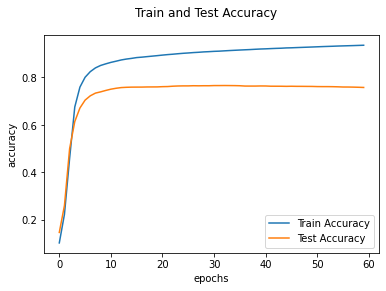

In [14]:
acc_train_plt, = plt.plot(log['train_accuracy'], label="Train Accuracy")
acc_test_plt, = plt.plot(log['test_accuracy'], label="Test Accuracy")
plt.legend(handles = [acc_train_plt, acc_test_plt])
plt.suptitle('Train and Test Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

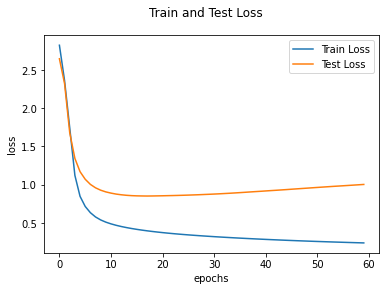

In [15]:
loss_train_plt, = plt.plot(log['train_loss'], label="Train Loss")
loss_test_plt, = plt.plot(log['test_loss'], label="Test Loss")
plt.legend(handles = [loss_train_plt, loss_test_plt])
plt.suptitle('Train and Test Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

As demonstrated in the plots above, increasing epochs will reduce cost function on training dataset, while cost function for test dataset increases, an evident sign of overfitting; also we can point to the fact that accuracy for training data does not drastically change after a certain epoch.

Certain solutions exist for avoiding overfitting in a neural network:

* Obviously, increasing epochs this far was not a bright idea; we can stop our network at an earlier point to avoid overfitting caused by simply reducing cost function to an extreme point.


* Simplifying our model can help in reducing the probability of overfitting (i.e., we can reduce count of nuerons or maybe remove a layer from our network.)


* In situations where we are working with picture data, augmenting the dataset by adding redundant rows can aid our attempt on reducing the chance of overfitting; we can increase the size of our dataset by adding pictures which are the original pictures but in a flipped or rescaled state.



* Regularization techniques can also be used for the same purpose.